In [ ]:
## import all libraries

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [ ]:
## download train and test dataset with normalize

batch_size = 128 # size of one batch for train


train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)) # standard normalize for mnist 
                       ])),
        batch_size=batch_size, shuffle=True)




test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
class ConvNet(nn.Module): 
    def __init__(self): 
        # initilization
        super().__init__()
        # first layer
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        # second layer
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        # drop out
        self.drop_out = nn.Dropout() 
        # two fully connected layers
        self.fc1 = nn.Linear(7 * 7 * 64, 1000) 
        self.fc2 = nn.Linear(1000, 10)


    def forward(self, x):
        # forward function for our layers 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

In [ ]:
model = ConvNet().to(device)
# create Adam optimization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create loss func
criterion = nn.CrossEntropyLoss()

In [ ]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

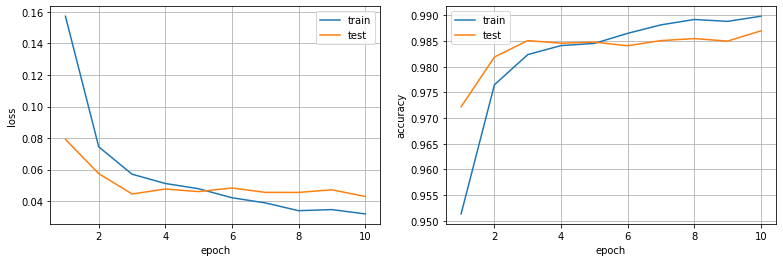

Best test accuracy: 0.987


In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()

    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]


    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)

        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()

    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')            

In [ ]:
print(f'Top-1 error: {(1 - test_accuracies[-1]):4.3f}')

Top-1 error: 0.013


By the way, here we don't need top2 or more accuracy, because now top1 error = 0.013 (predict almost always are right) and we have only 10 classes.

Next, we can look at some predictions of the model to get more familiar with the dataset. Let's print some images with real class and our predict

Class: 5
Predict: 5


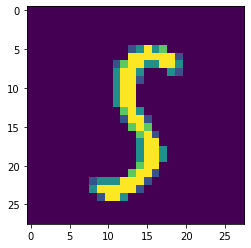

Class: 7
Predict: 7


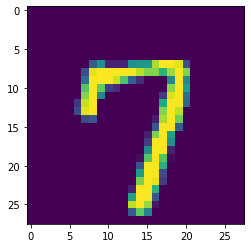

Class: 9
Predict: 9


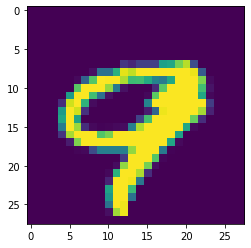

Class: 7
Predict: 7


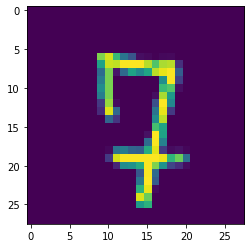

Class: 0
Predict: 0


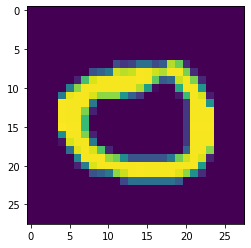

In [ ]:
exmp_batch, label_batch = next(iter(train_loader))

with torch.no_grad():
    logits = model(exmp_batch.to(device))
    preds = logits.argmax(dim=-1)

for i in range(1, 42, 10):
    print('Class:', label_batch[i].item())
    print('Predict:', preds[i].item())
    plt.imshow(exmp_batch[i].permute(1, 2, 0)[..., 0])
    plt.show()

Time to FSGM attack!

In [ ]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

In [ ]:
adv_imgs, noise_grad = fast_gradient_sign_method(model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = model(adv_imgs.to(device))
    new_preds = adv_preds.argmax(dim=-1)

Image


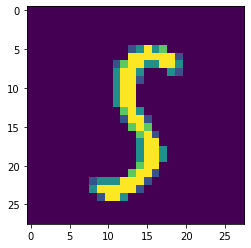

Adversarial


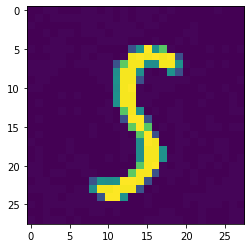

Noise


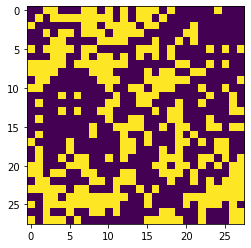

Real class: 5
Old predict: 5
New predict: 5
Image


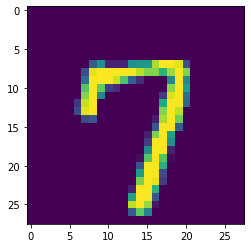

Adversarial


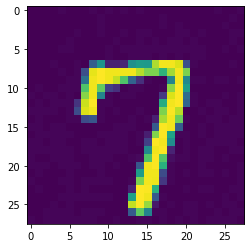

Noise


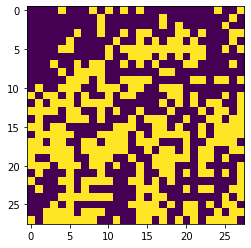

Real class: 7
Old predict: 7
New predict: 7
Image


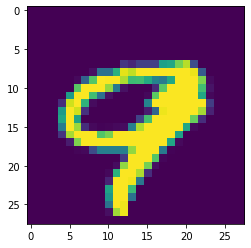

Adversarial


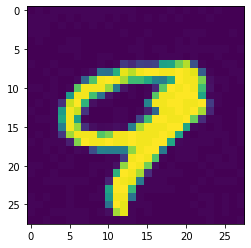

Noise


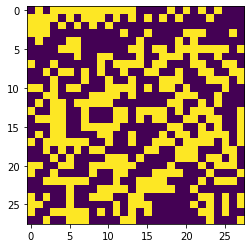

Real class: 9
Old predict: 9
New predict: 9
Image


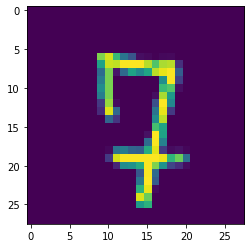

Adversarial


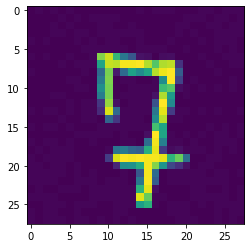

Noise


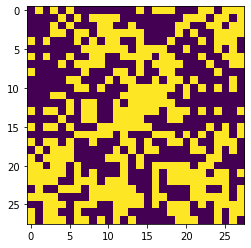

Real class: 7
Old predict: 7
New predict: 7
Image


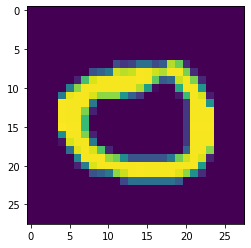

Adversarial


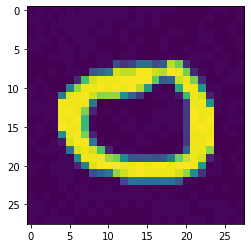

Noise


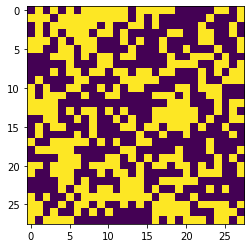

Real class: 0
Old predict: 0
New predict: 0


In [ ]:
for i in range(1, 42, 10):
    print('Image')
    plt.imshow(exmp_batch[i].permute(1, 2, 0)[..., 0])
    plt.show()

    print('Adversarial')
    plt.imshow(adv_imgs[i].permute(1, 2, 0)[..., 0])
    plt.show()

    print('Noise')
    plt.imshow(noise_grad[i].permute(1, 2, 0)[..., 0])
    plt.show()

    print('Real class:', label_batch[i].item())
    print('Old predict:', preds[i].item())
    print('New predict:', new_preds[i].item())

In [ ]:
for i in range(128):
    if (new_preds[i].item() != preds[i].item()):
        print('Real class:', label_batch[i].item())
        print('Old predict:', preds[i].item())
        print('New predict:', new_preds[i].item(), '\n')

Real class: 5
Old predict: 8
New predict: 5 

Real class: 6
Old predict: 6
New predict: 5 

Real class: 1
Old predict: 1
New predict: 2 



Image


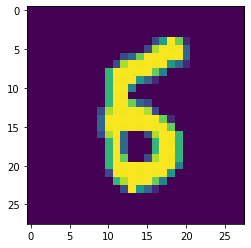

Adversarial


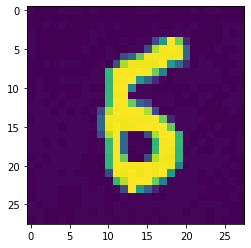

Noise


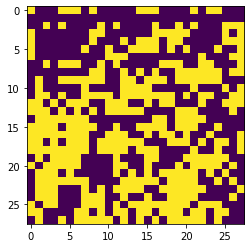

Real class: 5
Old predict: 8
New predict: 5 

Image


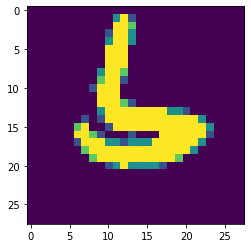

Adversarial


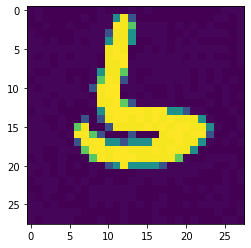

Noise


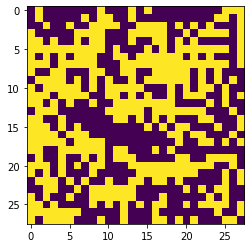

Real class: 6
Old predict: 6
New predict: 5 

Image


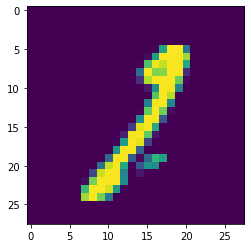

Adversarial


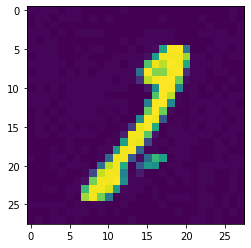

Noise


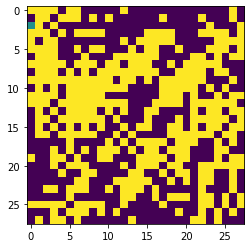

Real class: 1
Old predict: 1
New predict: 2 



In [ ]:
for i in range(128):
    if (new_preds[i].item() != preds[i].item()):
        print('Image')
        plt.imshow(exmp_batch[i].permute(1, 2, 0)[..., 0])
        plt.show()

        print('Adversarial')
        plt.imshow(adv_imgs[i].permute(1, 2, 0)[..., 0])
        plt.show()

        print('Noise')
        plt.imshow(noise_grad[i].permute(1, 2, 0)[..., 0])
        plt.show()

        print('Real class:', label_batch[i].item())
        print('Old predict:', preds[i].item())
        print('New predict:', new_preds[i].item(), '\n')

In [ ]:
test_accuracies_adv = []
running_accuracy = 0.0
for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    adv_imgs, noise_grad = fast_gradient_sign_method(model, images, labels, epsilon=0.02)

    with torch.no_grad():
        adv_preds = model(adv_imgs.to(device))

    running_accuracy += (adv_preds.argmax(dim=-1) == labels).sum().item()

test_accuracies_adv += [running_accuracy / len(test_loader.dataset)]
print(f'Top-1 error: {(1 - test_accuracies[-1]):4.3f}')
print(f'Top-1 adv error: {(1 - test_accuracies_adv[0]):4.3f}')

  0%|          | 0/79 [00:00<?, ?it/s]

Top-1 error: 0.013
Top-1 adv error: 0.018


:(

Let's try increase epsilon

In [ ]:
adv_imgs, noise_grad = fast_gradient_sign_method(model, exmp_batch, label_batch, epsilon=0.1)
with torch.no_grad():
    adv_preds = model(adv_imgs.to(device))
    new_preds = adv_preds.argmax(dim=-1)

In [ ]:
total = 0
for i in range(128):
    if (new_preds[i].item() != preds[i].item() and new_preds[i].item() != label_batch[i].item()):
        total += 1

print('broke with adv:', total)

broke with adv: 9


Image


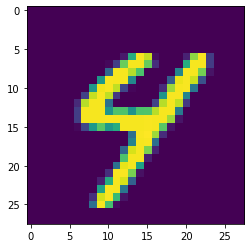

Adversarial


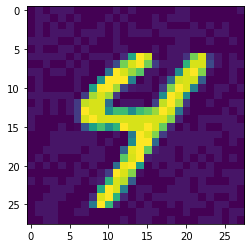

Real class: 4
Old predict: 4
New predict: 9 

Image


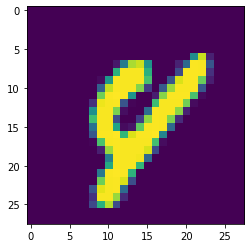

Adversarial


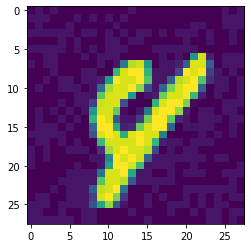

Real class: 4
Old predict: 4
New predict: 8 

Image


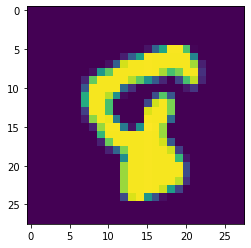

Adversarial


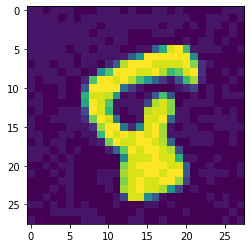

Real class: 8
Old predict: 8
New predict: 9 

Image


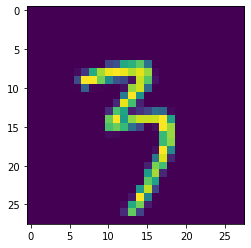

Adversarial


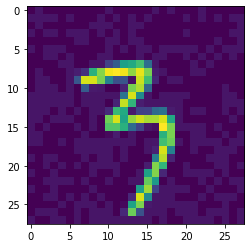

Real class: 3
Old predict: 3
New predict: 7 



In [ ]:
total = 0
for i in range(128):
    if (new_preds[i].item() != preds[i].item() and new_preds[i].item() != label_batch[i].item()):
        total += 1
        print('Image')
        plt.imshow(exmp_batch[i].permute(1, 2, 0)[..., 0])
        plt.show()

        print('Adversarial')
        plt.imshow(adv_imgs[i].permute(1, 2, 0)[..., 0])
        plt.show()

        print('Real class:', label_batch[i].item())
        print('Old predict:', preds[i].item())
        print('New predict:', new_preds[i].item(), '\n')
        if total > 3:
            break

Now noise on image is notable. But human still can easily see number

Let's increase more! Until human couldn't recognize number

In [ ]:
adv_imgs, noise_grad = fast_gradient_sign_method(model, exmp_batch, label_batch, epsilon=0.5)
with torch.no_grad():
    adv_preds = model(adv_imgs.to(device))
    new_preds = adv_preds.argmax(dim=-1)

In [ ]:
total = 0
for i in range(128):
    if (new_preds[i].item() != preds[i].item() and new_preds[i].item() != label_batch[i].item()):
        total += 1

print('broke with adv:', total)

broke with adv: 78


Image


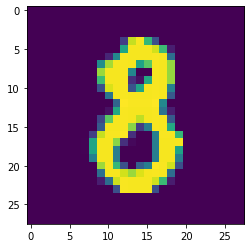

Adversarial


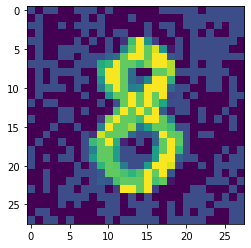

Real class: 8
Old predict: 8
New predict: 9 

Image


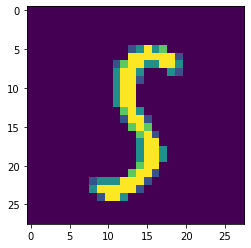

Adversarial


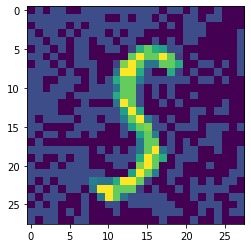

Real class: 5
Old predict: 5
New predict: 1 

Image


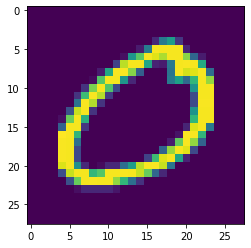

Adversarial


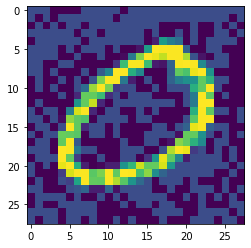

Real class: 0
Old predict: 0
New predict: 2 

Image


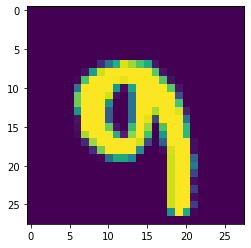

Adversarial


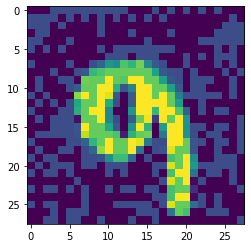

Real class: 9
Old predict: 9
New predict: 4 



In [ ]:
total = 0
for i in range(128):
    if (new_preds[i].item() != preds[i].item() and new_preds[i].item() != label_batch[i].item()):
        total += 1
        print('Image')
        plt.imshow(exmp_batch[i].permute(1, 2, 0)[..., 0])
        plt.show()

        print('Adversarial')
        plt.imshow(adv_imgs[i].permute(1, 2, 0)[..., 0])
        plt.show()

        print('Real class:', label_batch[i].item())
        print('Old predict:', preds[i].item())
        print('New predict:', new_preds[i].item(), '\n')
        if total > 3:
            break

Okay, let's stop here and check new accuracy.

In [ ]:
test_accuracies_adv = []
running_accuracy = 0.0
for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    adv_imgs, noise_grad = fast_gradient_sign_method(model, images, labels, epsilon=0.5)

    with torch.no_grad():
        adv_preds = model(adv_imgs.to(device))

    running_accuracy += (adv_preds.argmax(dim=-1) == labels).sum().item()

test_accuracies_adv += [running_accuracy / len(test_loader.dataset)]
print(f'Top-1 error: {(1 - test_accuracies[-1]):4.3f}')
print(f'Top-1 error with asversarial: {(1 - test_accuracies_adv[0]):4.3f}')

  0%|          | 0/79 [00:00<?, ?it/s]

Top-1 error: 0.013
Top-1 error with asversarial: 0.557


In [ ]:
test_accuracies_adv = []
running_accuracy = 0.0
for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    adv_imgs, noise_grad = fast_gradient_sign_method(model, images, labels, epsilon=1)

    with torch.no_grad():
        adv_preds = model(adv_imgs.to(device))

    running_accuracy += (adv_preds.argmax(dim=-1) == labels).sum().item()

test_accuracies_adv += [running_accuracy / len(test_loader.dataset)]
print(f'Top-1 error: {(1 - test_accuracies[-1]):4.3f}')
print(f'Top-1 error with asversarial: {(1 - test_accuracies_adv[0]):4.3f}')

  0%|          | 0/79 [00:00<?, ?it/s]

Top-1 error: 0.013
Top-1 error with asversarial: 0.770


In [ ]:
adv_imgs, noise_grad = fast_gradient_sign_method(model, exmp_batch, label_batch, epsilon=1)
with torch.no_grad():
    adv_preds = model(adv_imgs.to(device))
    new_preds = adv_preds.argmax(dim=-1)

Image


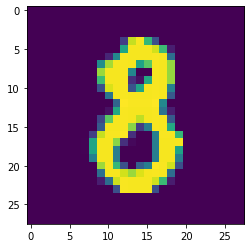

Adversarial


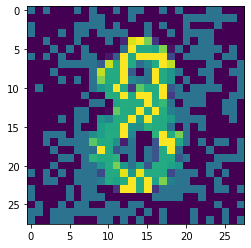

Real class: 8
Old predict: 8
New predict: 1 

Image


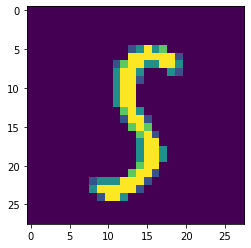

Adversarial


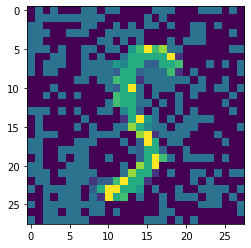

Real class: 5
Old predict: 5
New predict: 1 

Image


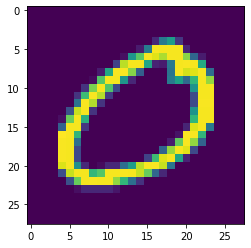

Adversarial


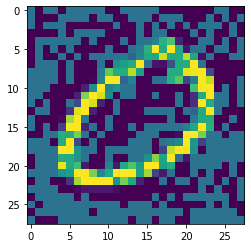

Real class: 0
Old predict: 0
New predict: 4 

Image


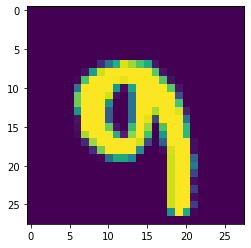

Adversarial


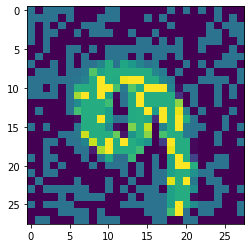

Real class: 9
Old predict: 9
New predict: 6 



In [ ]:
total = 0
for i in range(128):
    if (new_preds[i].item() != preds[i].item() and new_preds[i].item() != label_batch[i].item()):
        total += 1
        print('Image')
        plt.imshow(exmp_batch[i].permute(1, 2, 0)[..., 0])
        plt.show()

        print('Adversarial')
        plt.imshow(adv_imgs[i].permute(1, 2, 0)[..., 0])
        plt.show()

        print('Real class:', label_batch[i].item())
        print('Old predict:', preds[i].item())
        print('New predict:', new_preds[i].item(), '\n')
        if total > 3:
            break

We can increase epsilon more, but I don't think that it's necessary